## Notebook 1B:  Régression multivariée de la consommation d'énergie

**1. Preparation du Problème**

In [1]:
# a) Chargez les libraries
import pandas as pd
from pandas import set_option
from pandas import DataFrame

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from keras.layers import BatchNormalization, Dropout, Dense 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score

from pickle import dump

2023-10-08 10:24:28.997680: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# b) Chargez les dataset
# Charger et visualiser chaque fichier du dataset
data = pd.read_csv('EPB_data.csv', header=0)
print(data.shape)
print(data.head(10))
print(data.dtypes)

(768, 10)
   Relative Compactness  Surface Area  Wall Area  Roof Area  Overall Height  \
0                  0.98         514.5      294.0     110.25             7.0   
1                  0.98         514.5      294.0     110.25             7.0   
2                  0.98         514.5      294.0     110.25             7.0   
3                  0.98         514.5      294.0     110.25             7.0   
4                  0.90         563.5      318.5     122.50             7.0   
5                  0.90         563.5      318.5     122.50             7.0   
6                  0.90         563.5      318.5     122.50             7.0   
7                  0.90         563.5      318.5     122.50             7.0   
8                  0.86         588.0      294.0     147.00             7.0   
9                  0.86         588.0      294.0     147.00             7.0   

   Orientation  Glazing Area  Glazing Area Distribution  Heating Load  \
0            2           0.0                   

L'une des approches de l'optimisation de l'efficacité énergétique des bâtiments consiste à minimiser la consommation totale d'énergie, qui est la somme du chauffage et de la climatisation.

In [3]:
# Définissez les features et les labels
X = data.drop(columns=['Heating Load', 'Cooling Load'], axis = 1)
y = data[['Heating Load', 'Cooling Load']]
print(X.shape, y.shape)

(768, 8) (768, 2)


**2. Sommaire du Dataset**

In [4]:
# a) Statistiques descriptives
set_option("display.precision", 3)
print(data.describe())

       Relative Compactness  Surface Area  Wall Area  Roof Area  \
count               768.000       768.000    768.000    768.000   
mean                  0.764       671.708    318.500    176.604   
std                   0.106        88.086     43.626     45.166   
min                   0.620       514.500    245.000    110.250   
25%                   0.682       606.375    294.000    140.875   
50%                   0.750       673.750    318.500    183.750   
75%                   0.830       741.125    343.000    220.500   
max                   0.980       808.500    416.500    220.500   

       Overall Height  Orientation  Glazing Area  Glazing Area Distribution  \
count         768.000      768.000       768.000                    768.000   
mean            5.250        3.500         0.234                      2.812   
std             1.751        1.119         0.133                      1.551   
min             3.500        2.000         0.000                      0.000   
2

In [5]:
# vérification des caractéristiques catégorielles (categorical features)
cat_features = data.select_dtypes(include='O').keys()

cat_features

Index([], dtype='object')

/Users/user/Library/Python/3.8/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


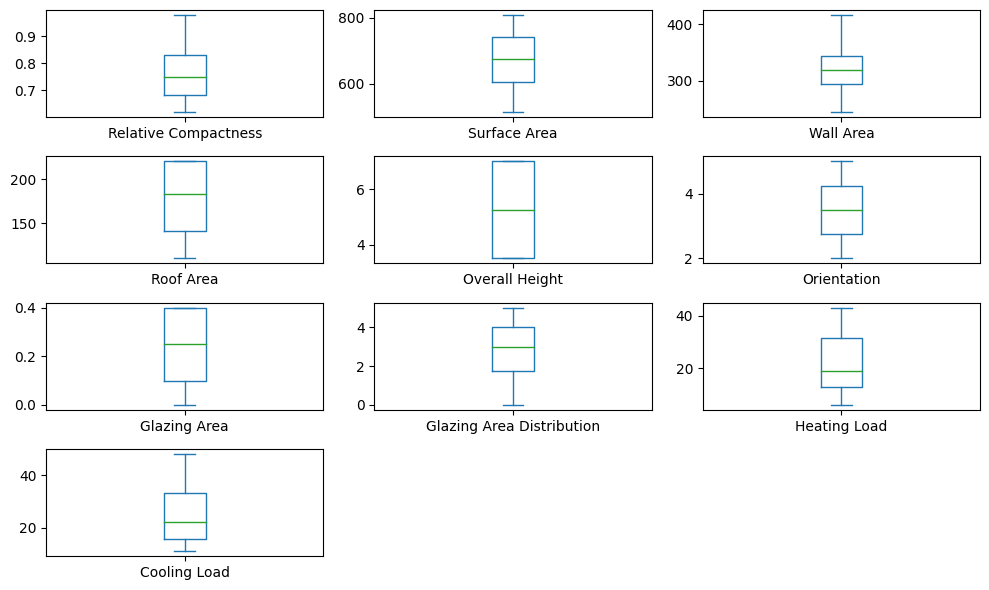

In [6]:
# b) Visualizations des données
# Box et Whisker Plots de quelques features

plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True

raw_plot = pd.DataFrame(data)
raw_plot.plot(kind='box', subplots=True, layout=(4,3), sharex=False, sharey=False)
plt.show()

Nous pouvons constater que les données sont biaisées vers des valeurs élevées en ce qui concerne la compacité relative, la surface de toit, la surface vitrée et la charge de refroidissement.

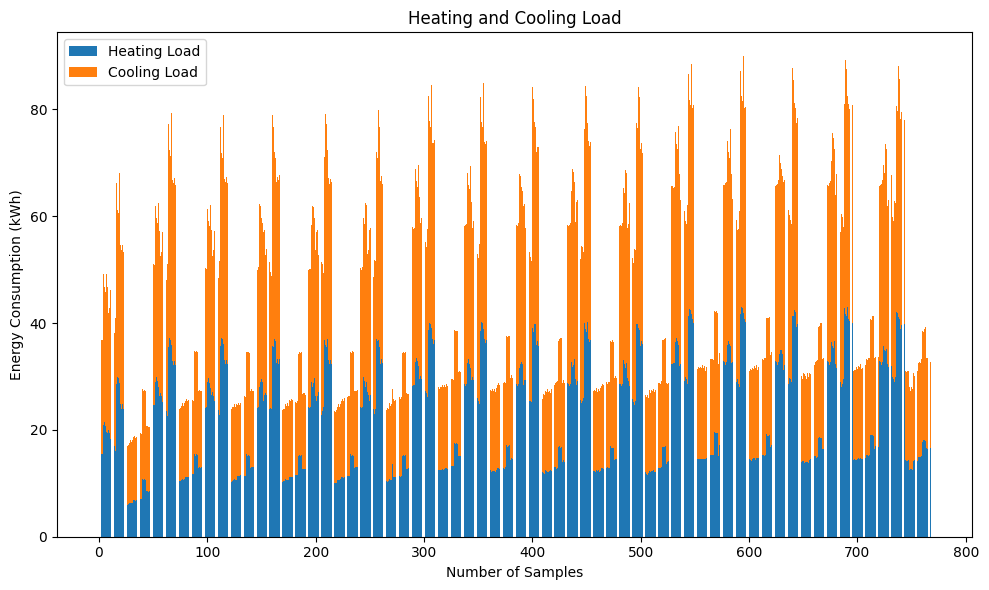

In [7]:
# créer l'histogramme de la charge de chauffage et de refroidissement
fig, ax = plt.subplots()
ax.bar(np.arange(len(data['Heating Load'])), data['Heating Load'], label='Heating Load')
ax.bar(np.arange(len(data['Cooling Load'])), data['Cooling Load'], bottom=data['Heating Load'], label='Cooling Load')

# ajout des labeles, titre et legende
ax.set_xlabel('Number of Samples')
ax.set_ylabel('Energy Consumption (kWh)')
ax.set_title('Heating and Cooling Load')
ax.legend()

# affichez le graphique
plt.show()

Les données présentent un schéma cyclique qui peut résulter des mesures prises les jours de semaine (avec des heures plus longues) et les week-ends.

/Users/user/Library/Python/3.8/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


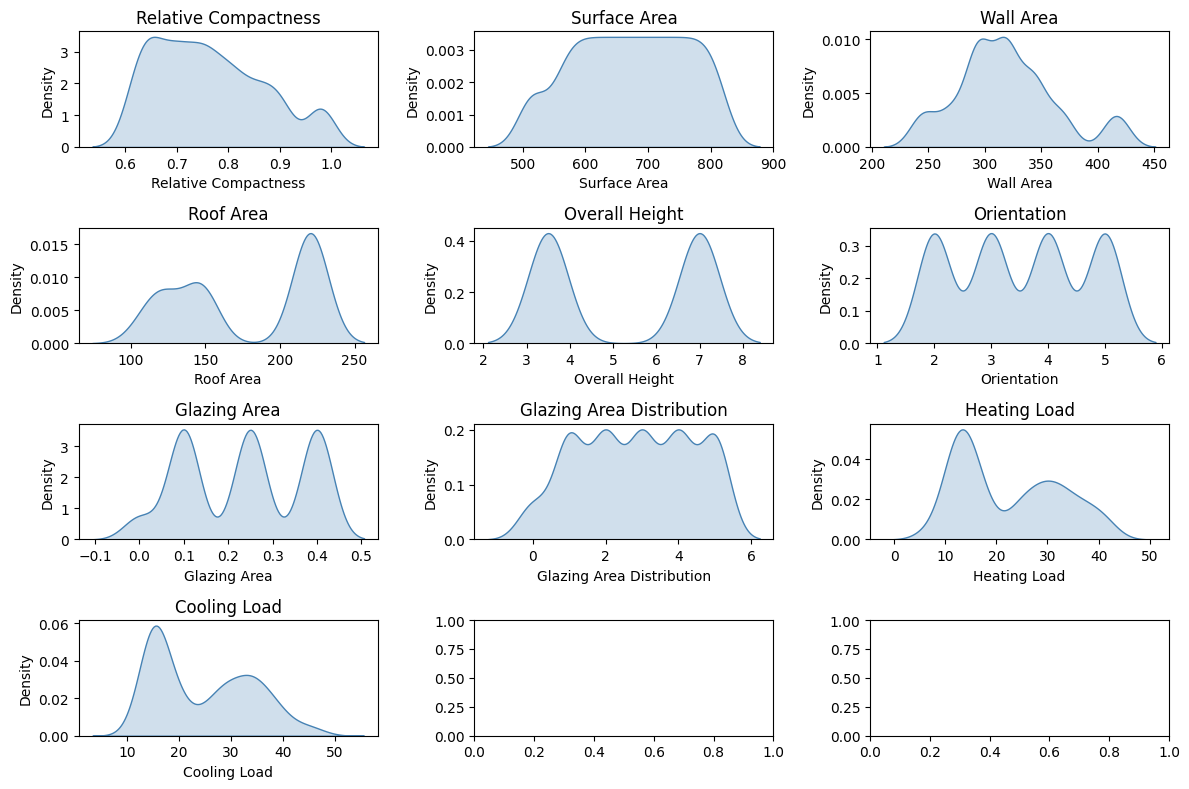

In [8]:
# Creation de figures avec subplots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 8))

# Applatissez (Flatten) les axes des array afin de simplifier l'affichage
axes = axes.flatten()

# Bouclez sur chaque caractéristique (feature) et créez un graphique de densité.
for i, feature in enumerate(raw_plot.columns):
    sns.kdeplot(raw_plot[feature], ax=axes[i], color='steelblue', fill=True)
    axes[i].set_title(feature)

# Ajuster la disposition et l'espacement des subplots
fig.tight_layout()

plt.show()

L'ensemble de données semble être complexe car la plupart des caractéristiques présentent des distributions non gaussiennes, à l'exception de la surface. Plusieurs facteurs peuvent être à l'origine de distributions non gaussiennes, notamment les valeurs aberrantes, les erreurs de mesure ou les caractéristiques inhérentes à la conception des bâtiments.

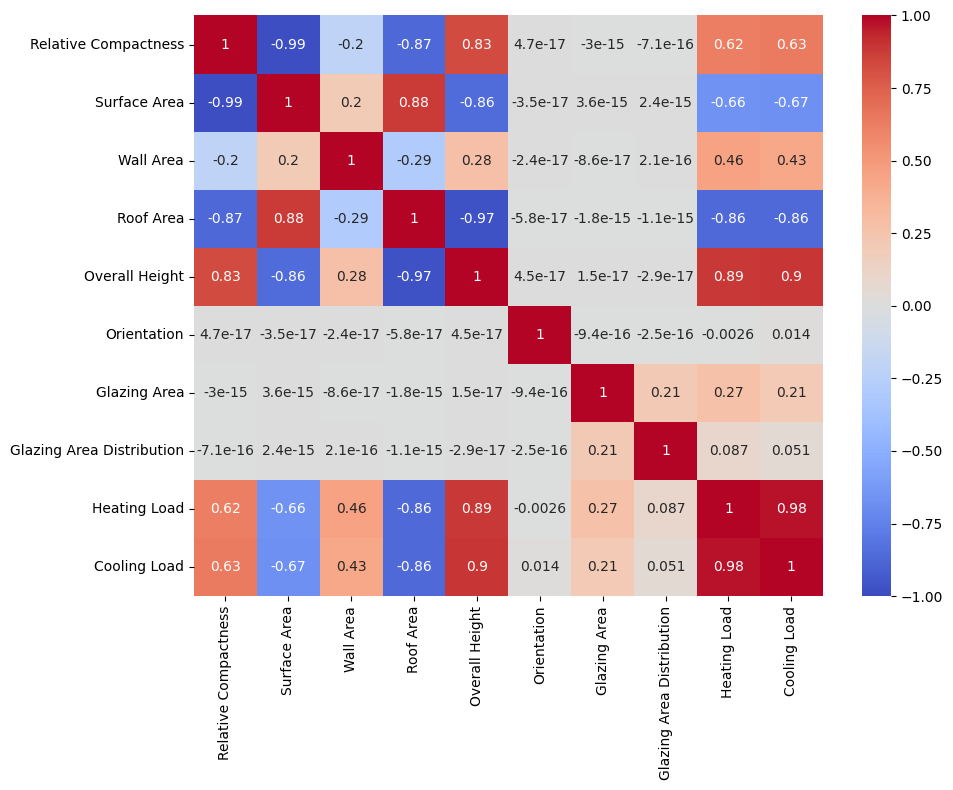

In [9]:
# matrice de corrélation entre toutes les paires d'attributs
corr_matrix = data.corr(method='pearson')

# Creation d'une heatmap avec seaborn
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, cmap="coolwarm", ax=ax)

plt.show()

Selon la matrice de corrélation, les charges de chauffage et de refroidissement, ainsi que la consommation d'énergie, présentent de fortes corrélations avec la hauteur totale, l'orientation et, dans une certaine mesure, la surface. L'orientation est considérée comme un facteur incertain dans la conception des bâtiments en raison des choix limités par rapport à d'autres variables, et elle joue un rôle important dans la détermination de l'efficacité énergétique d'un bâtiment.

**3. Preparation des données**

In [10]:
# a) Nettoyage des données
# résumer le nombre de valeurs uniques dans chaque colonne
print(data.nunique())

Relative Compactness          12
Surface Area                  12
Wall Area                      7
Roof Area                      4
Overall Height                 2
Orientation                    4
Glazing Area                   4
Glazing Area Distribution      6
Heating Load                 586
Cooling Load                 636
dtype: int64


In [11]:
# Identifier les colonnes avec des valeurs manquantes et compter le nombre de valeurs manquantes
data.columns[data.isnull().any()]
print(data.isnull().sum())

Relative Compactness         0
Surface Area                 0
Wall Area                    0
Roof Area                    0
Overall Height               0
Orientation                  0
Glazing Area                 0
Glazing Area Distribution    0
Heating Load                 0
Cooling Load                 0
dtype: int64


Il est nécessaire d'éliminer les valeurs aberrantes dans les colonnes de données numériques afin d'améliorer la précision des processus de formation et de validation. Pour ce faire, il convient de déterminer la corrélation entre ces colonnes et la variable cible, d'identifier les colonnes présentant une faible corrélation, puis de filtrer les valeurs qui se situent en dehors des limites inférieures et supérieures.

In [12]:
# calculer la corrélation entre les colonnes numériques et les variables cibles
corr_matrix = data.select_dtypes(include=np.number).corrwith(data['Heating Load']).sort_values(ascending=False)

# filtrer les colonnes à faible corrélation 
corr_threshold = 0.05
low_corr_columns = corr_matrix[corr_matrix.abs() < corr_threshold].index

# supprimer les valeurs aberrantes des colonnes numériques à faible corrélation
for column in low_corr_columns:
    lower = data[column].quantile(0.01)
    upper = data[column].quantile(0.99)
    data[column] = data[column].clip(lower, upper)

In [13]:
# calculer la corrélation entre les colonnes numériques et les variables cibles
corr_matrix = data.select_dtypes(include=np.number).corrwith(data['Cooling Load']).sort_values(ascending=False)

# filtrer les colonnes à faible corrélation 
corr_threshold = 0.05
low_corr_columns = corr_matrix[corr_matrix.abs() < corr_threshold].index

# supprimer les valeurs aberrantes des colonnes numériques à faible corrélation
for column in low_corr_columns:
    lower = data[column].quantile(0.01)
    upper = data[column].quantile(0.99)
    data[column] = data[column].clip(lower, upper)

In [14]:
# b) Diviser l'ensemble de données en ensembles de formation et de validation

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(576, 8) (576, 2) (192, 8) (192, 2)


In [15]:
# c) Transformation des données
# Normaliser le dataset en remettant à l'échelle la distribution des valeurs 

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)

**4. Evaluation des Algorithmes**

In [16]:
# a) Vérification des algorithmes à l'aide de la technique de validation croisée
num_folds = 8
seed = 8

# Sélectionner les 5 algorithmes linéaires et arborescents les plus populaires pour l'évaluation
models = []
models.append(('LR', LinearRegression()))
models.append(('EN', ElasticNet()))
models.append(('RF', RandomForestRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVR', MultiOutputRegressor(SVR(gamma='auto'))))

In [17]:
# Algorithmes de réseaux neuronaux
# creation modèle séquentiel keras
def baseline_model():
    model = Sequential()
    model.add(Dense(300, input_shape = (8, ), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(200, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(100, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(2))
    # Compile model
    model.compile(optimizer = 'adam',
                loss = 'mean_squared_error',
                metrics=['mse'])
    return model

# Construction du modèle
model_NN = baseline_model()
models.append(('NN', model_NN))

2023-10-08 10:24:42.289642: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
# Définir un rappel (callback) pour l'arrêt anticipé si la perte de validation ne s'améliore pas pendant 10 années consécutives. 
# epochs (patience=10).
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [19]:
results = []
alg_names = []

# Initialiser l'estimateur KerasRegressor avec un arrêt anticipé
estimator = KerasRegressor(model=model_NN, batch_size=128, verbose=1, callbacks=[early_stopping])

for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    
    # modification de la boucle pour NN
    if name != 'NN':
        cvs = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    else:    
        validation_data = (X_val, y_val)
        cvs = cross_val_score(estimator, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error', fit_params={'validation_data': validation_data, 'epochs': 150})
       
    results.append(cvs)
    alg_names.append(name)
    output = "%s: %f (%f)" % (name, cvs.mean(), cvs.std())
    print(output)

LR: -8.866738 (1.264777)
EN: -44.681735 (8.746579)
RF: -1.706690 (0.397662)
KNN: -8.516613 (2.132772)
SVR: -11.050826 (2.213697)


INFO:tensorflow:Assets written to: ram://680c8eb3c2b0450bb2b2ae8a2d99d146/assets


INFO:tensorflow:Assets written to: ram://680c8eb3c2b0450bb2b2ae8a2d99d146/assets


Epoch 1/150


2023-10-08 10:24:46.978879: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://16a4f927f9b14bc6a752614d8b0febee: INVALID_ARGUMENT: ram://16a4f927f9b14bc6a752614d8b0febee is a directory.


4/4 [==============================] - 1s 87ms/step - loss: 605.2352 - mse: 605.2352 - val_loss: 689.2961 - val_mse: 689.2961
Epoch 2/150
4/4 [==============================] - 0s 20ms/step - loss: 580.5312 - mse: 580.5312 - val_loss: 684.4656 - val_mse: 684.4656
Epoch 3/150
4/4 [==============================] - 0s 19ms/step - loss: 563.6371 - mse: 563.6371 - val_loss: 677.3830 - val_mse: 677.3830
Epoch 4/150
4/4 [==============================] - 0s 17ms/step - loss: 555.5590 - mse: 555.5590 - val_loss: 668.9874 - val_mse: 668.9874
Epoch 5/150
4/4 [==============================] - 0s 20ms/step - loss: 544.6169 - mse: 544.6169 - val_loss: 660.1730 - val_mse: 660.1730
Epoch 6/150
4/4 [==============================] - 0s 19ms/step - loss: 537.3175 - mse: 537.3175 - val_loss: 651.2952 - val_mse: 651.2952
Epoch 7/150
4/4 [==============================] - 0s 18ms/step - loss: 530.4868 - mse: 530.4868 - val_loss: 642.7796 - val_mse: 642.7796
Epoch 8/150
4/4 [=============================

4/4 [==============================] - 0s 17ms/step - loss: 224.8294 - mse: 224.8294 - val_loss: 261.5219 - val_mse: 261.5219
Epoch 61/150
4/4 [==============================] - 0s 16ms/step - loss: 216.4480 - mse: 216.4480 - val_loss: 249.5657 - val_mse: 249.5657
Epoch 62/150
4/4 [==============================] - 0s 17ms/step - loss: 212.1043 - mse: 212.1043 - val_loss: 237.7352 - val_mse: 237.7352
Epoch 63/150
4/4 [==============================] - 0s 17ms/step - loss: 203.4936 - mse: 203.4936 - val_loss: 228.1311 - val_mse: 228.1311
Epoch 64/150
4/4 [==============================] - 0s 17ms/step - loss: 197.6351 - mse: 197.6351 - val_loss: 219.1884 - val_mse: 219.1884
Epoch 65/150
4/4 [==============================] - 0s 16ms/step - loss: 186.0525 - mse: 186.0525 - val_loss: 212.1352 - val_mse: 212.1352
Epoch 66/150
4/4 [==============================] - 0s 17ms/step - loss: 178.1288 - mse: 178.1288 - val_loss: 206.2049 - val_mse: 206.2049
Epoch 67/150
4/4 [======================

4/4 [==============================] - 0s 17ms/step - loss: 24.7254 - mse: 24.7254 - val_loss: 11.7861 - val_mse: 11.7861
Epoch 121/150
4/4 [==============================] - 0s 16ms/step - loss: 25.5623 - mse: 25.5623 - val_loss: 11.8178 - val_mse: 11.8178
Epoch 122/150
4/4 [==============================] - 0s 15ms/step - loss: 24.4344 - mse: 24.4344 - val_loss: 11.2612 - val_mse: 11.2612
Epoch 123/150
4/4 [==============================] - 0s 16ms/step - loss: 24.5171 - mse: 24.5171 - val_loss: 10.6730 - val_mse: 10.6730
Epoch 124/150
4/4 [==============================] - 0s 17ms/step - loss: 25.3505 - mse: 25.3505 - val_loss: 10.5242 - val_mse: 10.5242
Epoch 125/150
4/4 [==============================] - 0s 17ms/step - loss: 22.5734 - mse: 22.5734 - val_loss: 10.6205 - val_mse: 10.6205
Epoch 126/150
4/4 [==============================] - 0s 16ms/step - loss: 25.0157 - mse: 25.0157 - val_loss: 10.8135 - val_mse: 10.8135
Epoch 127/150
4/4 [==============================] - 0s 17ms/s

INFO:tensorflow:Assets written to: ram://d7bee9b8873e491b9f22b30202301989/assets


INFO:tensorflow:Assets written to: ram://d7bee9b8873e491b9f22b30202301989/assets


Epoch 1/150


2023-10-08 10:25:00.781031: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a0f843b4c560410cb074f00ddee3a65c: INVALID_ARGUMENT: ram://a0f843b4c560410cb074f00ddee3a65c is a directory.


4/4 [==============================] - 1s 70ms/step - loss: 625.8323 - mse: 625.8323 - val_loss: 688.5427 - val_mse: 688.5427
Epoch 2/150
4/4 [==============================] - 0s 16ms/step - loss: 598.2560 - mse: 598.2560 - val_loss: 683.4946 - val_mse: 683.4946
Epoch 3/150
4/4 [==============================] - 0s 17ms/step - loss: 584.4760 - mse: 584.4760 - val_loss: 677.2469 - val_mse: 677.2469
Epoch 4/150
4/4 [==============================] - 0s 17ms/step - loss: 571.5449 - mse: 571.5449 - val_loss: 669.9507 - val_mse: 669.9507
Epoch 5/150
4/4 [==============================] - 0s 24ms/step - loss: 567.2865 - mse: 567.2865 - val_loss: 661.8917 - val_mse: 661.8917
Epoch 6/150
4/4 [==============================] - 0s 17ms/step - loss: 554.9960 - mse: 554.9960 - val_loss: 653.5356 - val_mse: 653.5356
Epoch 7/150
4/4 [==============================] - 0s 18ms/step - loss: 555.1941 - mse: 555.1941 - val_loss: 644.8487 - val_mse: 644.8487
Epoch 8/150
4/4 [=============================

4/4 [==============================] - 0s 17ms/step - loss: 238.2819 - mse: 238.2819 - val_loss: 257.6587 - val_mse: 257.6587
Epoch 61/150
4/4 [==============================] - 0s 16ms/step - loss: 222.3991 - mse: 222.3991 - val_loss: 250.0367 - val_mse: 250.0367
Epoch 62/150
4/4 [==============================] - 0s 17ms/step - loss: 218.5539 - mse: 218.5539 - val_loss: 240.9620 - val_mse: 240.9620
Epoch 63/150
4/4 [==============================] - 0s 17ms/step - loss: 213.9691 - mse: 213.9691 - val_loss: 230.7875 - val_mse: 230.7875
Epoch 64/150
4/4 [==============================] - 0s 17ms/step - loss: 204.4334 - mse: 204.4334 - val_loss: 219.5909 - val_mse: 219.5909
Epoch 65/150
4/4 [==============================] - 0s 16ms/step - loss: 197.4203 - mse: 197.4203 - val_loss: 208.9935 - val_mse: 208.9935
Epoch 66/150
4/4 [==============================] - 0s 17ms/step - loss: 189.9922 - mse: 189.9922 - val_loss: 198.5012 - val_mse: 198.5012
Epoch 67/150
4/4 [======================

4/4 [==============================] - 0s 27ms/step - loss: 25.7791 - mse: 25.7791 - val_loss: 10.8425 - val_mse: 10.8425
Epoch 121/150
4/4 [==============================] - 0s 18ms/step - loss: 25.0545 - mse: 25.0545 - val_loss: 10.4704 - val_mse: 10.4704
Epoch 122/150
4/4 [==============================] - 0s 17ms/step - loss: 24.4410 - mse: 24.4410 - val_loss: 10.1625 - val_mse: 10.1625
Epoch 123/150
4/4 [==============================] - 0s 17ms/step - loss: 26.5106 - mse: 26.5106 - val_loss: 9.8622 - val_mse: 9.8622
Epoch 124/150
4/4 [==============================] - 0s 18ms/step - loss: 23.0685 - mse: 23.0685 - val_loss: 9.7359 - val_mse: 9.7359
Epoch 125/150
4/4 [==============================] - 0s 17ms/step - loss: 23.1769 - mse: 23.1769 - val_loss: 9.7681 - val_mse: 9.7681
Epoch 126/150
4/4 [==============================] - 0s 21ms/step - loss: 25.5896 - mse: 25.5896 - val_loss: 9.8178 - val_mse: 9.8178
Epoch 127/150
4/4 [==============================] - 0s 17ms/step - lo

INFO:tensorflow:Assets written to: ram://606c4824941c4c48b3c9daa803809e4d/assets


INFO:tensorflow:Assets written to: ram://606c4824941c4c48b3c9daa803809e4d/assets


Epoch 1/150


2023-10-08 10:25:15.757064: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ada4526b4b05445ca9ee6c2d1311e8b0: INVALID_ARGUMENT: ram://ada4526b4b05445ca9ee6c2d1311e8b0 is a directory.


4/4 [==============================] - 1s 73ms/step - loss: 608.4521 - mse: 608.4521 - val_loss: 689.3711 - val_mse: 689.3711
Epoch 2/150
4/4 [==============================] - 0s 19ms/step - loss: 583.3306 - mse: 583.3306 - val_loss: 684.4651 - val_mse: 684.4651
Epoch 3/150
4/4 [==============================] - 0s 18ms/step - loss: 567.9155 - mse: 567.9155 - val_loss: 678.1113 - val_mse: 678.1113
Epoch 4/150
4/4 [==============================] - 0s 17ms/step - loss: 554.7456 - mse: 554.7456 - val_loss: 670.5479 - val_mse: 670.5479
Epoch 5/150
4/4 [==============================] - 0s 18ms/step - loss: 548.1797 - mse: 548.1796 - val_loss: 661.8371 - val_mse: 661.8371
Epoch 6/150
4/4 [==============================] - 0s 18ms/step - loss: 543.4568 - mse: 543.4568 - val_loss: 652.4548 - val_mse: 652.4548
Epoch 7/150
4/4 [==============================] - 0s 18ms/step - loss: 538.1367 - mse: 538.1367 - val_loss: 643.1151 - val_mse: 643.1151
Epoch 8/150
4/4 [=============================

4/4 [==============================] - 0s 18ms/step - loss: 222.9300 - mse: 222.9300 - val_loss: 254.9469 - val_mse: 254.9469
Epoch 61/150
4/4 [==============================] - 0s 16ms/step - loss: 216.6124 - mse: 216.6124 - val_loss: 243.7518 - val_mse: 243.7518
Epoch 62/150
4/4 [==============================] - 0s 17ms/step - loss: 214.7204 - mse: 214.7204 - val_loss: 231.3189 - val_mse: 231.3189
Epoch 63/150
4/4 [==============================] - 0s 16ms/step - loss: 201.7554 - mse: 201.7554 - val_loss: 222.1850 - val_mse: 222.1850
Epoch 64/150
4/4 [==============================] - 0s 18ms/step - loss: 199.2656 - mse: 199.2656 - val_loss: 213.4889 - val_mse: 213.4889
Epoch 65/150
4/4 [==============================] - 0s 17ms/step - loss: 184.7682 - mse: 184.7682 - val_loss: 206.7514 - val_mse: 206.7514
Epoch 66/150
4/4 [==============================] - 0s 17ms/step - loss: 182.2549 - mse: 182.2549 - val_loss: 201.2296 - val_mse: 201.2296
Epoch 67/150
4/4 [======================

4/4 [==============================] - 0s 18ms/step - loss: 26.0112 - mse: 26.0112 - val_loss: 13.0214 - val_mse: 13.0214
Epoch 121/150
4/4 [==============================] - 0s 17ms/step - loss: 22.3481 - mse: 22.3481 - val_loss: 13.2091 - val_mse: 13.2091
Epoch 122/150
4/4 [==============================] - 0s 16ms/step - loss: 25.5427 - mse: 25.5427 - val_loss: 13.2591 - val_mse: 13.2591
Epoch 123/150
4/4 [==============================] - 0s 17ms/step - loss: 23.4867 - mse: 23.4867 - val_loss: 12.7576 - val_mse: 12.7576
Epoch 124/150
4/4 [==============================] - 0s 17ms/step - loss: 24.8914 - mse: 24.8914 - val_loss: 11.9595 - val_mse: 11.9595
Epoch 125/150
4/4 [==============================] - 0s 17ms/step - loss: 23.4415 - mse: 23.4415 - val_loss: 11.1981 - val_mse: 11.1981
Epoch 126/150
4/4 [==============================] - 0s 18ms/step - loss: 23.4529 - mse: 23.4529 - val_loss: 10.5168 - val_mse: 10.5168
Epoch 127/150
4/4 [==============================] - 0s 18ms/s

INFO:tensorflow:Assets written to: ram://c6a69343edaa4f9ebfe939cdeafe016b/assets


INFO:tensorflow:Assets written to: ram://c6a69343edaa4f9ebfe939cdeafe016b/assets


Epoch 1/150


2023-10-08 10:25:29.933248: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://58f350fbda4c458980273bbeb9f7a1ef: INVALID_ARGUMENT: ram://58f350fbda4c458980273bbeb9f7a1ef is a directory.


4/4 [==============================] - 1s 70ms/step - loss: 617.6792 - mse: 617.6792 - val_loss: 689.3945 - val_mse: 689.3945
Epoch 2/150
4/4 [==============================] - 0s 17ms/step - loss: 596.1805 - mse: 596.1805 - val_loss: 684.1309 - val_mse: 684.1309
Epoch 3/150
4/4 [==============================] - 0s 16ms/step - loss: 572.0958 - mse: 572.0958 - val_loss: 677.0696 - val_mse: 677.0696
Epoch 4/150
4/4 [==============================] - 0s 17ms/step - loss: 563.7411 - mse: 563.7411 - val_loss: 669.1353 - val_mse: 669.1353
Epoch 5/150
4/4 [==============================] - 0s 17ms/step - loss: 558.2316 - mse: 558.2316 - val_loss: 660.3850 - val_mse: 660.3850
Epoch 6/150
4/4 [==============================] - 0s 17ms/step - loss: 551.2327 - mse: 551.2327 - val_loss: 651.2141 - val_mse: 651.2141
Epoch 7/150
4/4 [==============================] - 0s 17ms/step - loss: 548.7990 - mse: 548.7990 - val_loss: 641.6194 - val_mse: 641.6194
Epoch 8/150
4/4 [=============================

4/4 [==============================] - 0s 22ms/step - loss: 234.5055 - mse: 234.5055 - val_loss: 246.6465 - val_mse: 246.6465
Epoch 61/150
4/4 [==============================] - 0s 17ms/step - loss: 222.9709 - mse: 222.9709 - val_loss: 236.9899 - val_mse: 236.9899
Epoch 62/150
4/4 [==============================] - 0s 17ms/step - loss: 215.9379 - mse: 215.9379 - val_loss: 228.6041 - val_mse: 228.6041
Epoch 63/150
4/4 [==============================] - 0s 17ms/step - loss: 208.3635 - mse: 208.3635 - val_loss: 220.6199 - val_mse: 220.6199
Epoch 64/150
4/4 [==============================] - 0s 17ms/step - loss: 197.5352 - mse: 197.5352 - val_loss: 213.0518 - val_mse: 213.0518
Epoch 65/150
4/4 [==============================] - 0s 16ms/step - loss: 189.9564 - mse: 189.9564 - val_loss: 207.4726 - val_mse: 207.4726
Epoch 66/150
4/4 [==============================] - 0s 17ms/step - loss: 182.5142 - mse: 182.5142 - val_loss: 200.2369 - val_mse: 200.2369
Epoch 67/150
4/4 [======================

4/4 [==============================] - 0s 17ms/step - loss: 24.7604 - mse: 24.7604 - val_loss: 10.8314 - val_mse: 10.8314
Epoch 121/150
4/4 [==============================] - 0s 17ms/step - loss: 26.5593 - mse: 26.5593 - val_loss: 10.2947 - val_mse: 10.2947
Epoch 122/150
4/4 [==============================] - 0s 17ms/step - loss: 23.0731 - mse: 23.0731 - val_loss: 9.8480 - val_mse: 9.8480
Epoch 123/150
4/4 [==============================] - 0s 17ms/step - loss: 22.5487 - mse: 22.5487 - val_loss: 9.6378 - val_mse: 9.6378
Epoch 124/150
4/4 [==============================] - 0s 17ms/step - loss: 23.4140 - mse: 23.4140 - val_loss: 9.6728 - val_mse: 9.6728
Epoch 125/150
4/4 [==============================] - 0s 17ms/step - loss: 24.1280 - mse: 24.1280 - val_loss: 9.7252 - val_mse: 9.7252
Epoch 126/150
4/4 [==============================] - 0s 17ms/step - loss: 25.0516 - mse: 25.0516 - val_loss: 9.6697 - val_mse: 9.6697
Epoch 127/150
4/4 [==============================] - 0s 17ms/step - loss

INFO:tensorflow:Assets written to: ram://6fa1544a21974fd984c4116146bf258b/assets


INFO:tensorflow:Assets written to: ram://6fa1544a21974fd984c4116146bf258b/assets


Epoch 1/150


2023-10-08 10:25:43.329666: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9d44b583a24e4e03afa510b9e9724421: INVALID_ARGUMENT: ram://9d44b583a24e4e03afa510b9e9724421 is a directory.


4/4 [==============================] - 1s 70ms/step - loss: 623.5588 - mse: 623.5588 - val_loss: 688.8415 - val_mse: 688.8415
Epoch 2/150
4/4 [==============================] - 0s 16ms/step - loss: 598.1938 - mse: 598.1938 - val_loss: 684.2473 - val_mse: 684.2473
Epoch 3/150
4/4 [==============================] - 0s 17ms/step - loss: 583.0065 - mse: 583.0065 - val_loss: 678.2332 - val_mse: 678.2332
Epoch 4/150
4/4 [==============================] - 0s 18ms/step - loss: 571.7125 - mse: 571.7125 - val_loss: 670.9356 - val_mse: 670.9356
Epoch 5/150
4/4 [==============================] - 0s 17ms/step - loss: 564.2200 - mse: 564.2200 - val_loss: 662.6873 - val_mse: 662.6873
Epoch 6/150
4/4 [==============================] - 0s 18ms/step - loss: 556.6376 - mse: 556.6376 - val_loss: 653.7940 - val_mse: 653.7940
Epoch 7/150
4/4 [==============================] - 0s 23ms/step - loss: 552.7866 - mse: 552.7866 - val_loss: 644.5223 - val_mse: 644.5223
Epoch 8/150
4/4 [=============================

4/4 [==============================] - 0s 19ms/step - loss: 238.0249 - mse: 238.0249 - val_loss: 249.4750 - val_mse: 249.4750
Epoch 61/150
4/4 [==============================] - 0s 16ms/step - loss: 230.4591 - mse: 230.4591 - val_loss: 239.2374 - val_mse: 239.2374
Epoch 62/150
4/4 [==============================] - 0s 17ms/step - loss: 216.4238 - mse: 216.4238 - val_loss: 231.4924 - val_mse: 231.4924
Epoch 63/150
4/4 [==============================] - 0s 18ms/step - loss: 214.2052 - mse: 214.2052 - val_loss: 226.9971 - val_mse: 226.9971
Epoch 64/150
4/4 [==============================] - 0s 16ms/step - loss: 205.9929 - mse: 205.9929 - val_loss: 221.7030 - val_mse: 221.7030
Epoch 65/150
4/4 [==============================] - 0s 18ms/step - loss: 200.4773 - mse: 200.4773 - val_loss: 213.0744 - val_mse: 213.0744
Epoch 66/150
4/4 [==============================] - 0s 17ms/step - loss: 184.0205 - mse: 184.0205 - val_loss: 202.6838 - val_mse: 202.6838
Epoch 67/150
4/4 [======================

4/4 [==============================] - 0s 18ms/step - loss: 25.1876 - mse: 25.1876 - val_loss: 12.1168 - val_mse: 12.1168
Epoch 121/150
4/4 [==============================] - 0s 16ms/step - loss: 23.4423 - mse: 23.4423 - val_loss: 12.2793 - val_mse: 12.2793
Epoch 122/150
4/4 [==============================] - 0s 17ms/step - loss: 24.7100 - mse: 24.7100 - val_loss: 11.3669 - val_mse: 11.3669
Epoch 123/150
4/4 [==============================] - 0s 17ms/step - loss: 26.3254 - mse: 26.3254 - val_loss: 10.5454 - val_mse: 10.5454
Epoch 124/150
4/4 [==============================] - 0s 17ms/step - loss: 22.4932 - mse: 22.4932 - val_loss: 9.8496 - val_mse: 9.8496
Epoch 125/150
4/4 [==============================] - 0s 18ms/step - loss: 26.4367 - mse: 26.4367 - val_loss: 9.7901 - val_mse: 9.7901
Epoch 126/150
4/4 [==============================] - 0s 18ms/step - loss: 25.4460 - mse: 25.4460 - val_loss: 9.7628 - val_mse: 9.7628
Epoch 127/150
4/4 [==============================] - 0s 17ms/step - 

1/1 [==============================] - 0s 103ms/step


INFO:tensorflow:Assets written to: ram://80e4fc01c875404d9b4f7235fcb14b2b/assets


INFO:tensorflow:Assets written to: ram://80e4fc01c875404d9b4f7235fcb14b2b/assets


Epoch 1/150


2023-10-08 10:25:57.219912: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c1b186c07c3a449696b413a6f064338d: INVALID_ARGUMENT: ram://c1b186c07c3a449696b413a6f064338d is a directory.


4/4 [==============================] - 1s 70ms/step - loss: 606.6868 - mse: 606.6868 - val_loss: 689.0760 - val_mse: 689.0760
Epoch 2/150
4/4 [==============================] - 0s 18ms/step - loss: 576.7706 - mse: 576.7706 - val_loss: 684.1040 - val_mse: 684.1040
Epoch 3/150
4/4 [==============================] - 0s 17ms/step - loss: 567.8018 - mse: 567.8018 - val_loss: 677.2424 - val_mse: 677.2424
Epoch 4/150
4/4 [==============================] - 0s 17ms/step - loss: 552.4896 - mse: 552.4896 - val_loss: 669.5560 - val_mse: 669.5560
Epoch 5/150
4/4 [==============================] - 0s 18ms/step - loss: 544.3865 - mse: 544.3865 - val_loss: 661.1091 - val_mse: 661.1091
Epoch 6/150
4/4 [==============================] - 0s 18ms/step - loss: 539.7306 - mse: 539.7306 - val_loss: 652.1254 - val_mse: 652.1254
Epoch 7/150
4/4 [==============================] - 0s 17ms/step - loss: 537.6261 - mse: 537.6261 - val_loss: 643.1301 - val_mse: 643.1301
Epoch 8/150
4/4 [=============================

4/4 [==============================] - 0s 18ms/step - loss: 230.5042 - mse: 230.5042 - val_loss: 255.6421 - val_mse: 255.6421
Epoch 61/150
4/4 [==============================] - 0s 17ms/step - loss: 223.8171 - mse: 223.8171 - val_loss: 247.3113 - val_mse: 247.3113
Epoch 62/150
4/4 [==============================] - 0s 18ms/step - loss: 212.0281 - mse: 212.0281 - val_loss: 238.3584 - val_mse: 238.3584
Epoch 63/150
4/4 [==============================] - 0s 16ms/step - loss: 204.1182 - mse: 204.1182 - val_loss: 228.7935 - val_mse: 228.7935
Epoch 64/150
4/4 [==============================] - 0s 17ms/step - loss: 188.9987 - mse: 188.9987 - val_loss: 221.3454 - val_mse: 221.3454
Epoch 65/150
4/4 [==============================] - 0s 17ms/step - loss: 184.3754 - mse: 184.3754 - val_loss: 212.4469 - val_mse: 212.4469
Epoch 66/150
4/4 [==============================] - 0s 18ms/step - loss: 178.1407 - mse: 178.1407 - val_loss: 202.1374 - val_mse: 202.1374
Epoch 67/150
4/4 [======================

4/4 [==============================] - 0s 18ms/step - loss: 21.8635 - mse: 21.8635 - val_loss: 12.5813 - val_mse: 12.5813
Epoch 121/150
4/4 [==============================] - 0s 16ms/step - loss: 23.0509 - mse: 23.0509 - val_loss: 12.5384 - val_mse: 12.5384
Epoch 122/150
4/4 [==============================] - 0s 17ms/step - loss: 23.0618 - mse: 23.0618 - val_loss: 12.5455 - val_mse: 12.5455
Epoch 123/150
4/4 [==============================] - 0s 18ms/step - loss: 21.4763 - mse: 21.4763 - val_loss: 11.6971 - val_mse: 11.6971
Epoch 124/150
4/4 [==============================] - 0s 17ms/step - loss: 19.4881 - mse: 19.4881 - val_loss: 11.1873 - val_mse: 11.1873
Epoch 125/150
4/4 [==============================] - 0s 18ms/step - loss: 21.0400 - mse: 21.0400 - val_loss: 11.0385 - val_mse: 11.0385
Epoch 126/150
4/4 [==============================] - 0s 18ms/step - loss: 22.4330 - mse: 22.4330 - val_loss: 10.5612 - val_mse: 10.5612
Epoch 127/150
4/4 [==============================] - 0s 18ms/s

1/1 [==============================] - 0s 100ms/step


INFO:tensorflow:Assets written to: ram://1d0be83a7a634ca4b4aa6d7de229769a/assets


INFO:tensorflow:Assets written to: ram://1d0be83a7a634ca4b4aa6d7de229769a/assets


Epoch 1/150


2023-10-08 10:26:10.817313: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e4aeff3597e44ee99743f20c7a139c04: INVALID_ARGUMENT: ram://e4aeff3597e44ee99743f20c7a139c04 is a directory.


1/4 [======>.......................] - ETA: 2s - loss: 641.2199 - mse: 641.2199WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


4/4 [==============================] - 1s 161ms/step - loss: 623.7684 - mse: 623.7684 - val_loss: 689.0163 - val_mse: 689.0163
Epoch 2/150
4/4 [==============================] - 0s 17ms/step - loss: 597.3833 - mse: 597.3833 - val_loss: 684.5637 - val_mse: 684.5637
Epoch 3/150
4/4 [==============================] - 0s 17ms/step - loss: 579.1146 - mse: 579.1146 - val_loss: 678.3929 - val_mse: 678.3929
Epoch 4/150
4/4 [==============================] - 0s 17ms/step - loss: 571.2112 - mse: 571.2112 - val_loss: 670.8585 - val_mse: 670.8585
Epoch 5/150
4/4 [==============================] - 0s 16ms/step - loss: 561.2433 - mse: 561.2433 - val_loss: 662.2587 - val_mse: 662.2587
Epoch 6/150
4/4 [==============================] - 0s 17ms/step - loss: 550.2359 - mse: 550.2359 - val_loss: 653.1315 - val_mse: 653.1315
Epoch 7/150
4/4 [==============================] - 0s 17ms/step - loss: 551.3771 - mse: 551.3771 - val_loss: 644.5518 - val_mse: 644.5518
Epoch 8/150
4/4 [============================

4/4 [==============================] - 0s 18ms/step - loss: 240.7142 - mse: 240.7142 - val_loss: 242.6412 - val_mse: 242.6412
Epoch 61/150
4/4 [==============================] - 0s 17ms/step - loss: 235.2995 - mse: 235.2995 - val_loss: 236.1692 - val_mse: 236.1692
Epoch 62/150
4/4 [==============================] - 0s 16ms/step - loss: 217.5460 - mse: 217.5460 - val_loss: 229.6603 - val_mse: 229.6603
Epoch 63/150
4/4 [==============================] - 0s 17ms/step - loss: 209.4368 - mse: 209.4368 - val_loss: 223.7921 - val_mse: 223.7921
Epoch 64/150
4/4 [==============================] - 0s 17ms/step - loss: 205.9269 - mse: 205.9269 - val_loss: 218.1248 - val_mse: 218.1248
Epoch 65/150
4/4 [==============================] - 0s 18ms/step - loss: 194.9851 - mse: 194.9851 - val_loss: 212.1066 - val_mse: 212.1066
Epoch 66/150
4/4 [==============================] - 0s 17ms/step - loss: 188.8602 - mse: 188.8602 - val_loss: 205.0421 - val_mse: 205.0421
Epoch 67/150
4/4 [======================

4/4 [==============================] - 0s 18ms/step - loss: 25.4786 - mse: 25.4786 - val_loss: 13.3832 - val_mse: 13.3832
Epoch 121/150
4/4 [==============================] - 0s 18ms/step - loss: 22.9055 - mse: 22.9055 - val_loss: 13.0983 - val_mse: 13.0983
Epoch 122/150
4/4 [==============================] - 0s 18ms/step - loss: 21.8266 - mse: 21.8266 - val_loss: 12.3760 - val_mse: 12.3760
Epoch 123/150
4/4 [==============================] - 0s 17ms/step - loss: 23.8516 - mse: 23.8516 - val_loss: 11.9389 - val_mse: 11.9389
Epoch 124/150
4/4 [==============================] - 0s 17ms/step - loss: 23.7449 - mse: 23.7449 - val_loss: 11.7197 - val_mse: 11.7197
Epoch 125/150
4/4 [==============================] - 0s 16ms/step - loss: 23.0160 - mse: 23.0160 - val_loss: 11.5155 - val_mse: 11.5155
Epoch 126/150
4/4 [==============================] - 0s 17ms/step - loss: 22.3233 - mse: 22.3233 - val_loss: 11.6123 - val_mse: 11.6123
Epoch 127/150
4/4 [==============================] - 0s 18ms/s

INFO:tensorflow:Assets written to: ram://a39fb48d90cf475d8203342939036de0/assets


INFO:tensorflow:Assets written to: ram://a39fb48d90cf475d8203342939036de0/assets


Epoch 1/150


2023-10-08 10:26:24.728166: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://45b8f1761bb84d4bac56a672d182f0cb: INVALID_ARGUMENT: ram://45b8f1761bb84d4bac56a672d182f0cb is a directory.


4/4 [==============================] - 1s 71ms/step - loss: 605.4547 - mse: 605.4547 - val_loss: 688.1905 - val_mse: 688.1905
Epoch 2/150
4/4 [==============================] - 0s 18ms/step - loss: 579.4881 - mse: 579.4881 - val_loss: 683.1079 - val_mse: 683.1079
Epoch 3/150
4/4 [==============================] - 0s 17ms/step - loss: 564.5402 - mse: 564.5402 - val_loss: 677.1953 - val_mse: 677.1953
Epoch 4/150
4/4 [==============================] - 0s 17ms/step - loss: 555.3774 - mse: 555.3774 - val_loss: 669.8943 - val_mse: 669.8943
Epoch 5/150
4/4 [==============================] - 0s 17ms/step - loss: 542.7526 - mse: 542.7526 - val_loss: 661.6835 - val_mse: 661.6835
Epoch 6/150
4/4 [==============================] - 0s 17ms/step - loss: 537.0009 - mse: 537.0009 - val_loss: 653.1389 - val_mse: 653.1389
Epoch 7/150
4/4 [==============================] - 0s 17ms/step - loss: 533.9614 - mse: 533.9614 - val_loss: 643.9821 - val_mse: 643.9821
Epoch 8/150
4/4 [=============================

4/4 [==============================] - 0s 17ms/step - loss: 226.9382 - mse: 226.9382 - val_loss: 246.4446 - val_mse: 246.4446
Epoch 61/150
4/4 [==============================] - 0s 17ms/step - loss: 216.9395 - mse: 216.9395 - val_loss: 234.1157 - val_mse: 234.1157
Epoch 62/150
4/4 [==============================] - 0s 17ms/step - loss: 209.5743 - mse: 209.5743 - val_loss: 224.8844 - val_mse: 224.8844
Epoch 63/150
4/4 [==============================] - 0s 17ms/step - loss: 203.9281 - mse: 203.9281 - val_loss: 215.6108 - val_mse: 215.6108
Epoch 64/150
4/4 [==============================] - 0s 17ms/step - loss: 195.7383 - mse: 195.7383 - val_loss: 206.9456 - val_mse: 206.9456
Epoch 65/150
4/4 [==============================] - 0s 17ms/step - loss: 181.4543 - mse: 181.4543 - val_loss: 197.0245 - val_mse: 197.0245
Epoch 66/150
4/4 [==============================] - 0s 18ms/step - loss: 174.0339 - mse: 174.0339 - val_loss: 189.0455 - val_mse: 189.0455
Epoch 67/150
4/4 [======================

4/4 [==============================] - 0s 19ms/step - loss: 24.8980 - mse: 24.8980 - val_loss: 12.8614 - val_mse: 12.8614
Epoch 121/150
4/4 [==============================] - 0s 17ms/step - loss: 24.4127 - mse: 24.4127 - val_loss: 12.5819 - val_mse: 12.5819
Epoch 122/150
4/4 [==============================] - 0s 17ms/step - loss: 23.3705 - mse: 23.3705 - val_loss: 11.8546 - val_mse: 11.8546
Epoch 123/150
4/4 [==============================] - 0s 17ms/step - loss: 21.8095 - mse: 21.8095 - val_loss: 11.3553 - val_mse: 11.3553
Epoch 124/150
4/4 [==============================] - 0s 17ms/step - loss: 24.2484 - mse: 24.2484 - val_loss: 10.6053 - val_mse: 10.6053
Epoch 125/150
4/4 [==============================] - 0s 17ms/step - loss: 22.7030 - mse: 22.7030 - val_loss: 9.8250 - val_mse: 9.8250
Epoch 126/150
4/4 [==============================] - 0s 17ms/step - loss: 21.2783 - mse: 21.2783 - val_loss: 9.5713 - val_mse: 9.5713
Epoch 127/150
4/4 [==============================] - 0s 17ms/step 

Epoch 1/500
5/5 [==============================] - 2s 55ms/step - loss: 610.2441 - mse: 610.2441 - val_loss: 687.2752 - val_mse: 687.2752
Epoch 2/500
5/5 [==============================] - 0s 16ms/step - loss: 583.8725 - mse: 583.8725 - val_loss: 680.6146 - val_mse: 680.6146
Epoch 3/500
5/5 [==============================] - 0s 16ms/step - loss: 565.6649 - mse: 565.6649 - val_loss: 671.9760 - val_mse: 671.9760
Epoch 4/500
5/5 [==============================] - 0s 16ms/step - loss: 555.1262 - mse: 555.1262 - val_loss: 661.6481 - val_mse: 661.6481
Epoch 5/500
5/5 [==============================] - 0s 15ms/step - loss: 547.5905 - mse: 547.5905 - val_loss: 651.7055 - val_mse: 651.7055
Epoch 6/500
5/5 [==============================] - 0s 16ms/step - loss: 541.1288 - mse: 541.1288 - val_loss: 641.9513 - val_mse: 641.9513
Epoch 7/500
5/5 [==============================] - 0s 16ms/step - loss: 533.1325 - mse: 533.1325 - val_loss: 632.1058 - val_mse: 632.1058
Epoch 8/500
5/5 [=================

5/5 [==============================] - 0s 15ms/step - loss: 125.7924 - mse: 125.7924 - val_loss: 137.3521 - val_mse: 137.3521
Epoch 61/500
5/5 [==============================] - 0s 13ms/step - loss: 122.1750 - mse: 122.1750 - val_loss: 132.0502 - val_mse: 132.0502
Epoch 62/500
5/5 [==============================] - 0s 14ms/step - loss: 112.9465 - mse: 112.9465 - val_loss: 125.8316 - val_mse: 125.8316
Epoch 63/500
5/5 [==============================] - 0s 13ms/step - loss: 106.5110 - mse: 106.5110 - val_loss: 122.1639 - val_mse: 122.1639
Epoch 64/500
5/5 [==============================] - 0s 14ms/step - loss: 102.5265 - mse: 102.5265 - val_loss: 117.0956 - val_mse: 117.0956
Epoch 65/500
5/5 [==============================] - 0s 13ms/step - loss: 93.6704 - mse: 93.6704 - val_loss: 108.5070 - val_mse: 108.5070
Epoch 66/500
5/5 [==============================] - 0s 14ms/step - loss: 88.8840 - mse: 88.8840 - val_loss: 102.0428 - val_mse: 102.0428
Epoch 67/500
5/5 [==========================

/Users/user/Library/Python/3.8/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


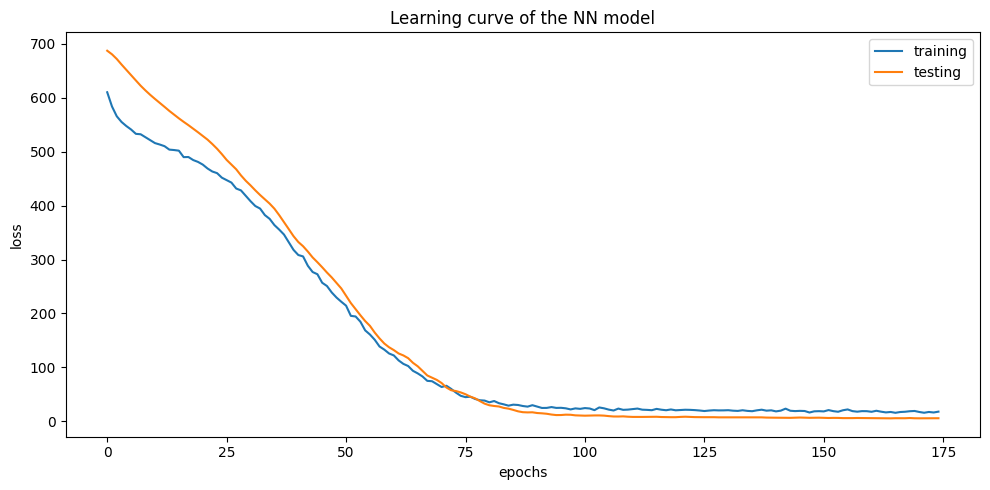

In [20]:
# Tracer la courbe d'apprentissage du modèle NN
history = model_NN.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=128, callbacks=[early_stopping])

plt.figure(figsize = (10, 5))
plt.plot(history.history['loss'], label = 'training')
plt.plot(history.history['val_loss'], label = 'testing')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Learning curve of the NN model')
plt.legend()

/Users/user/Library/Python/3.8/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


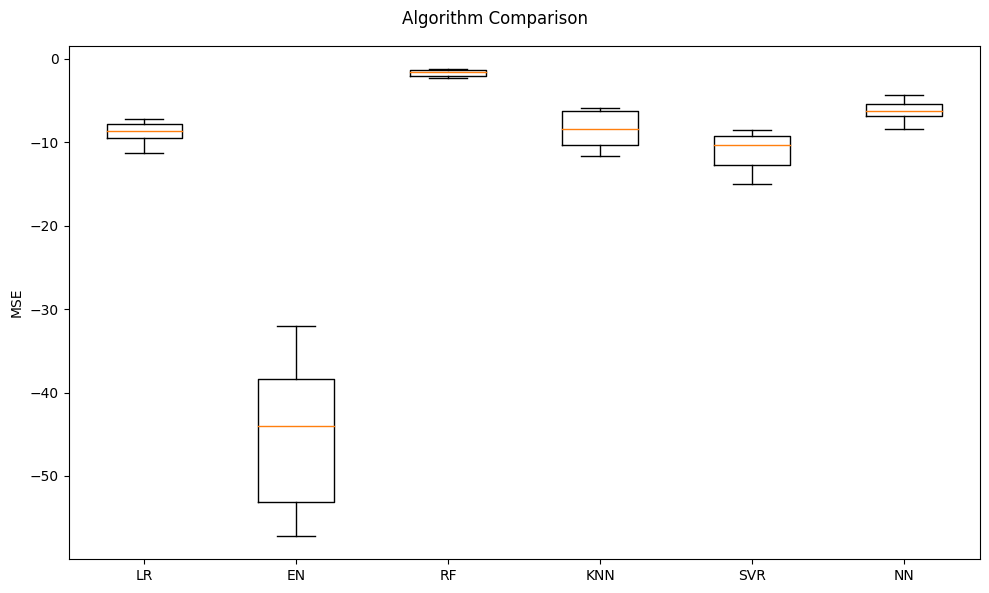

In [21]:
# b) Comparer les algorithmes et le modèle NN
# Distribution des valeurs de précision calculées sur 8 plis ou folds de validation croisée.
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot()
plt.boxplot(results)
ax.set_xticklabels(alg_names)
plt.ylabel("MSE")
plt.show()

L'algorithme Random Forest a démontré des performances supérieures à celles des cinq autres algorithmes d'apprentissage automatique et du modèle de réseau neuronal.

Dans un problème de régression, il est courant d'utiliser l'erreur moyenne comme mesure de validation. Pour ce faire, on calcule d'abord l'erreur absolue moyenne (EAM) des données de test par rapport à la moyenne de l'ensemble de données, puis l'EAM des données de test par rapport aux données prédites. 

In [22]:
# Évaluer les performances de l'algorithme Random Forest sur les données de validation
model_RF = RandomForestRegressor()
model_RF.fit(X_train, y_train)
y_pred_RF = model_RF.predict(X_val)
mae_pred_RF = mean_absolute_error(y_val, y_pred_RF)
print("Mean Absolute Error of predicted data: ", mae_pred_RF)

Mean Absolute Error of predicted data:  0.8460744791666671


In [23]:
# Évaluer les performances de l'algorithme NN sur les données de validation
model_NN.fit(X_train, y_train)
y_pred_NN = model_NN.predict(X_val)
print(y_pred_NN.shape)
mae_pred_NN = mean_absolute_error(y_val, y_pred_NN)
print("Mean Absolute Error of predicted data: ", mae_pred_NN)

6/6 [==============================] - 0s 2ms/step
(192, 2)
Mean Absolute Error of predicted data:  1.7243316881358624


In [24]:
# Définir la ligne de base de l'erreur moyenne absolue de y_val dans l'ensemble de données
y_mean = np.mean(y)
y_mean = np.array([y_mean]*len(y_val))
mae_ori = mean_absolute_error(y_val, y_mean)
print("Mean Absolute Error of original data: ", mae_ori)

Mean Absolute Error of original data:  8.900351223415804


/Users/user/Library/Python/3.8/lib/python/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Les valeurs MAE obtenues montrent que Random Forest semble meilleur que le modèle de réseau neuronal en termes de performance de prédiction. Par souci de simplicité, j'ai choisi Random Forest comme modèle de substitution pour le processus d'optimisation multi-objectifs.

**5. Finalisez le modèle**

In [25]:
# a) Obtenir les meilleurs paramètres du modèle
model_params = model_RF.get_params()

# Affichez les paramètres du modèle
print(model_params)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


/Users/user/Library/Python/3.8/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


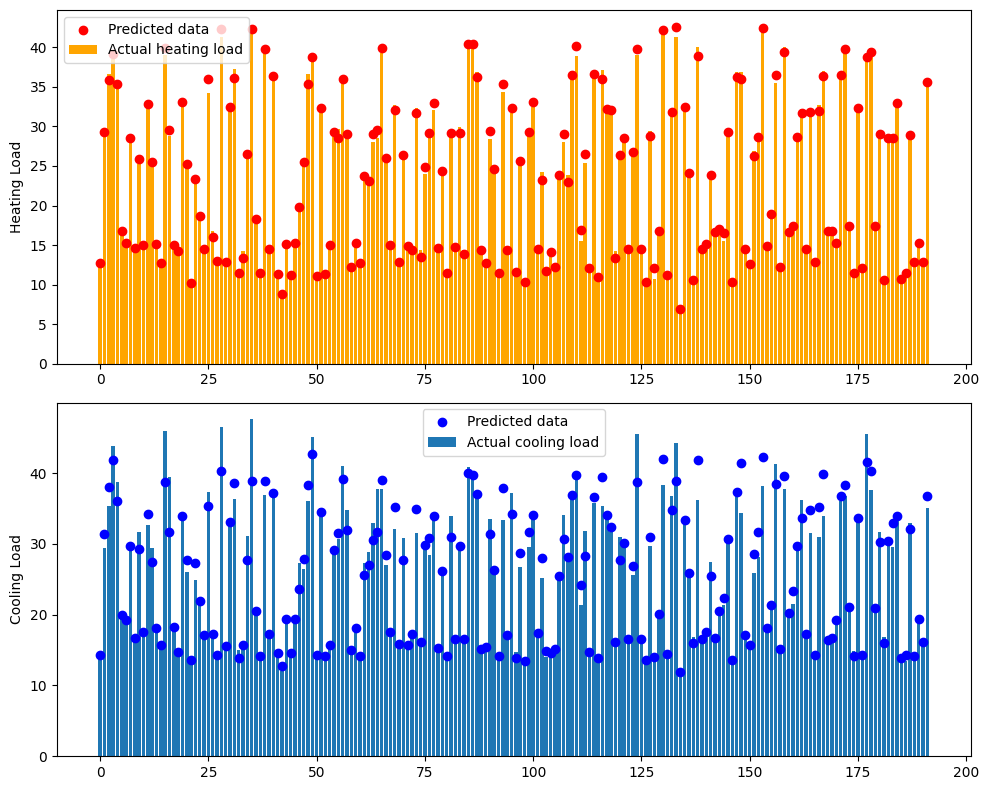

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Tracer la charge de chauffage réelle et prévue
ax1.bar(np.arange(len(y_val)), y_val.iloc[:, 0], label='Actual heating load', color='orange')
ax1.scatter(np.arange(len(y_pred_RF)), y_pred_RF[:, 0], label='Predicted data', color='red')
ax1.set_ylabel('Heating Load')
ax1.legend()

# Tracer la charge de refroidissement réelle et prévue
ax2.bar(np.arange(len(y_val)), y_val.iloc[:, 1], label='Actual cooling load')
ax2.scatter(np.arange(len(y_pred_RF)), y_pred_RF[:, 1], label='Predicted data', color='blue')
ax2.set_ylabel('Cooling Load')
ax2.legend()

# Afficher le graphique
plt.show()

In [27]:
# b) Savegardez le modèle
filename = 'finalized_model_multivariate.sav'
dump(model_RF, open(filename, 'wb'))

**6. Conclusions**

- L'analyse exploratoire des données indique que la plupart des variables d'entrée présentent une distribution non gaussienne.

- Sur la base de notre évaluation de cinq algorithmes d'apprentissage automatique et d'un modèle de réseau neuronal, nous avons sélectionné Random Forest comme modèle de substitution pour l'optimisation multi-objectifs en raison de son score élevé en validation croisée et de ses faibles valeurs d'erreur quadratique moyenne.

- Les valeurs de l'erreur absolue moyenne suggèrent que la précision de la prédiction est généralement bonne, bien que l'algorithme ElasticNet puisse nécessiter des améliorations supplémentaires.

- Les résultats indiquent que les performances du modèle de réseau neuronal séquentiel Keras sont comparables à celles d'autres algorithmes d'apprentissage automatique, et qu'un réglage plus poussé des hyperparamètres peut améliorer sa précision prédictive.